## Gene Expression Over Specific Time Frames

In [1]:
# Import necessary modules
import csv
import numpy as np
import pandas as pd
from pandas import DataFrame

In [2]:
# Import annotation data
annotation_df = pd.read_csv("data/JNJ2297.annotation.tsv", sep="\t")
print(annotation_df.shape)
print('Each row in the annotation dataframe represents a sample from a specific patient at a specific time point.')
print('Genes are clustered into four clusters [M.1, M.2, M.3, M.4], and the columns are the mean value of those clusters')
annotation_df.head()

(95, 9)
Each row in the annotation dataframe represents a sample from a specific patient at a specific time point.
Genes are clustered into four clusters [M.1, M.2, M.3, M.4], and the columns are the mean value of those clusters


,Gender,Age,Height.cm,Weight.kg,M.1,M.2,M.3,M.4,time
1,Female,46.65,NaN,NaN,-2.981974,1.409330,-0.217659,1.772206,9
2,Female,30.33,NaN,NaN,-2.600316,1.359622,0.023615,1.944382,9
3,Female,83.81,149.3,47.6,-2.740580,1.506242,0.162396,2.574374,2
4,Female,43.13,168,61.2,-2.113714,0.859283,0.506133,2.652673,5
5,Male,18.13,170.18,86.0,-1.885751,-0.938905,1.797638,6.198975,1


#### Create dataframe of just gene clusters and time

In [3]:
cluster_by_time_df = annotation_df[['M.1', 'M.2', 'M.3', 'M.4', 'time']]
cluster_by_time_df = cluster_by_time_df.melt('time', var_name='gene_cluster',  value_name='mean_cluster_value')
print(cluster_by_time_df.shape)
cluster_by_time_df.head()

(380, 3)


,time,gene_cluster,mean_cluster_value
0,9,M.1,-2.981974
1,9,M.1,-2.600316
2,2,M.1,-2.740580
3,5,M.1,-2.113714
4,1,M.1,-1.885751


#### Use K-Means to Group Data by Mean Cluster Values (4 categories: Reduced, Low, Medium, and High Expression)

In [4]:
from sklearn.cluster import KMeans

In [5]:
values = list(cluster_by_time_df['mean_cluster_value'])
print(len(values))
points = [(x,) for x in values]
len(points)

380


380

In [6]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(points)
ranges = kmeans.cluster_centers_.tolist()
flattened_ranges = [val for sublist in ranges for val in sublist]
ranges, flattened_ranges, len(kmeans.labels_)

([[0.6645488835329342],
  [4.876978140714285],
  [-1.9086897460999996],
  [2.421674266470588]],
 [0.6645488835329342,
  4.876978140714285,
  -1.9086897460999996,
  2.421674266470588],
 380)

In [7]:
# Create cluster map
cluster_map = pd.DataFrame()
cluster_map['data_values'] = values
cluster_map['cluster'] = kmeans.labels_  
print(cluster_map.shape)
cluster_map.head()

(380, 2)


,data_values,cluster
0,-2.981974,2
1,-2.600316,2
2,-2.740580,2
3,-2.113714,2
4,-1.885751,2


In [8]:
print(len(cluster_map.loc[cluster_map['cluster'] == 0]), cluster_map.loc[cluster_map['cluster'] == 0].max())
print(len(cluster_map.loc[cluster_map['cluster'] == 1]), cluster_map.loc[cluster_map['cluster'] == 1].max())
print(len(cluster_map.loc[cluster_map['cluster'] == 2]), cluster_map.loc[cluster_map['cluster'] == 2].max())
print(len(cluster_map.loc[cluster_map['cluster'] == 3]), cluster_map.loc[cluster_map['cluster'] == 3].max())

167 data_values    1.523842
cluster        0.000000
dtype: float64
28 data_values    7.351665
cluster        1.000000
dtype: float64
100 data_values   -0.691443
cluster        2.000000
dtype: float64
85 data_values    3.600801
cluster        3.000000
dtype: float64


In [9]:
# Label centers
kmeans_centers = []
for cluster in cluster_map['cluster']:
    
    if cluster == 2:
        kmeans_centers.append('(-)')
        
    elif cluster == 0:
        kmeans_centers.append('Low (+)')
    
    elif cluster == 3:
        kmeans_centers.append('Medium (+)')
    
    elif cluster == 1:
        kmeans_centers.append('High (+)')

In [10]:
# Add centers to cluster_by_time_df
cluster_by_time_df['Gene Expression Value'] = pd.Series(kmeans_centers, index=np.arange(0, 380))
cluster_by_time_df.tail()

,time,gene_cluster,mean_cluster_value,Gene Expression Value
375,9,M.4,2.347195,Medium (+)
376,9,M.4,1.339848,Low (+)
377,1,M.4,2.461429,Medium (+)
378,9,M.4,3.427726,Medium (+)
379,9,M.4,2.459665,Medium (+)


In [11]:
cluster_by_time_df.head()

,time,gene_cluster,mean_cluster_value,Gene Expression Value
0,9,M.1,-2.981974,(-)
1,9,M.1,-2.600316,(-)
2,2,M.1,-2.740580,(-)
3,5,M.1,-2.113714,(-)
4,1,M.1,-1.885751,(-)


In [114]:
m1 = cluster_by_time_df[cluster_by_time_df.gene_cluster == 'M.1']
m1[m1.time == 4]

,time,gene_cluster,mean_cluster_value,Gene Expression Value
39,4,M.1,2.668524,Medium (+)
62,4,M.1,-1.251874,(-)
63,4,M.1,-3.148599,(-)


#### Visualize Data

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

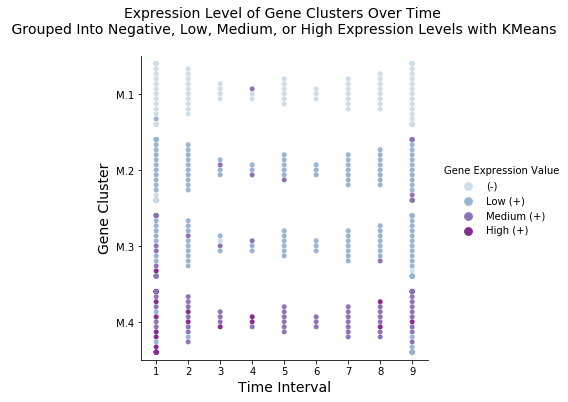

In [93]:
g = sns.catplot(x='time',
                y='gene_cluster',
                hue='Gene Expression Value', 
                data=cluster_by_time_df, 
                kind='swarm',
                palette='BuPu')
plt.title('Expression Level of Gene Clusters Over Time \n Grouped Into Negative, Low, Medium, or High Expression Levels with KMeans \n', size=14)
plt.xlabel('Time Interval', size=14)
plt.ylabel('Gene Cluster', size=14)
plt.show()

In [105]:
def plot_expression_over_time(cluster):

    # Select cluster df
    cluster_df = cluster_by_time_df.loc[cluster_by_time_df['gene_cluster'] == cluster]
    
    # Order by gene expression level
    cluster_df = cluster_df.sort_values(by=['mean_cluster_value'])
    
    # Initialize a grid of plots with an Axes for each cluster
    grid = sns.FacetGrid(cluster_df,
                         col='time', 
                         row='gene_cluster',
                         hue='Gene Expression Value',
                         palette='BuPu')

    # Draw a line plot to show the trajectory of each cluster
    grid = (grid.map(plt.hist, 'mean_cluster_value')).add_legend()

    plt.show()

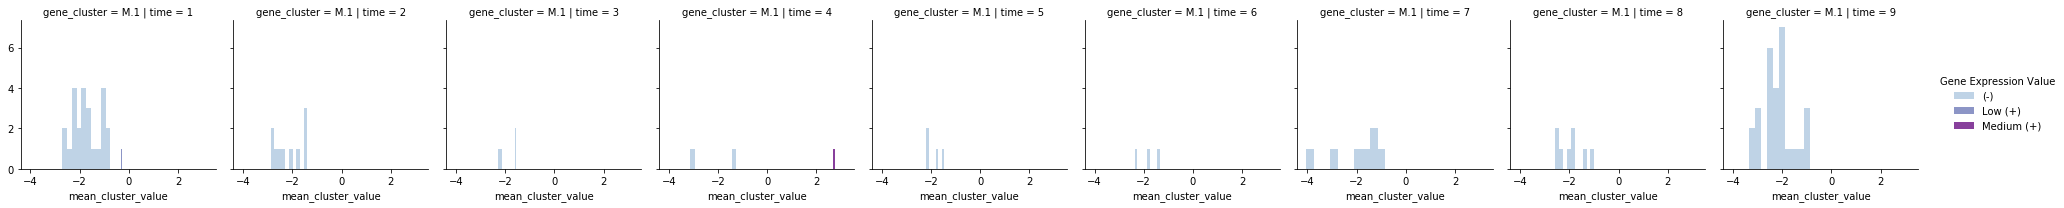

In [106]:
plot_expression_over_time('M.1')

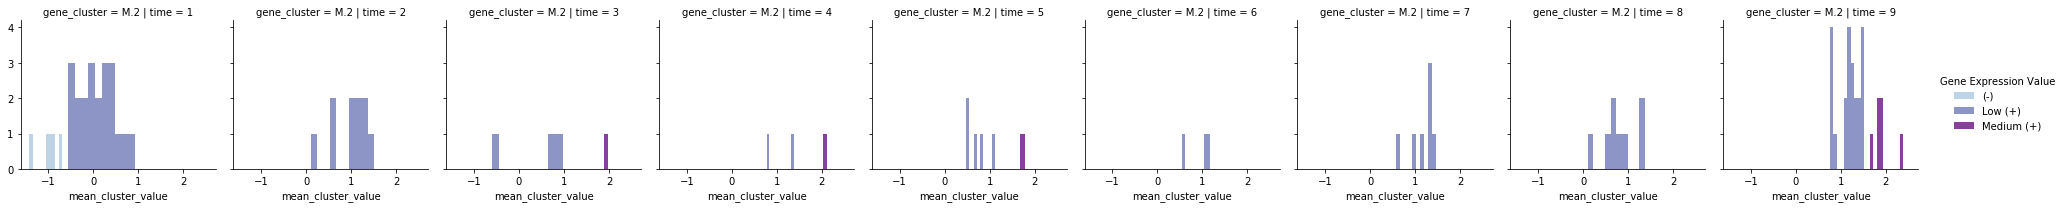

In [107]:
plot_expression_over_time('M.2')

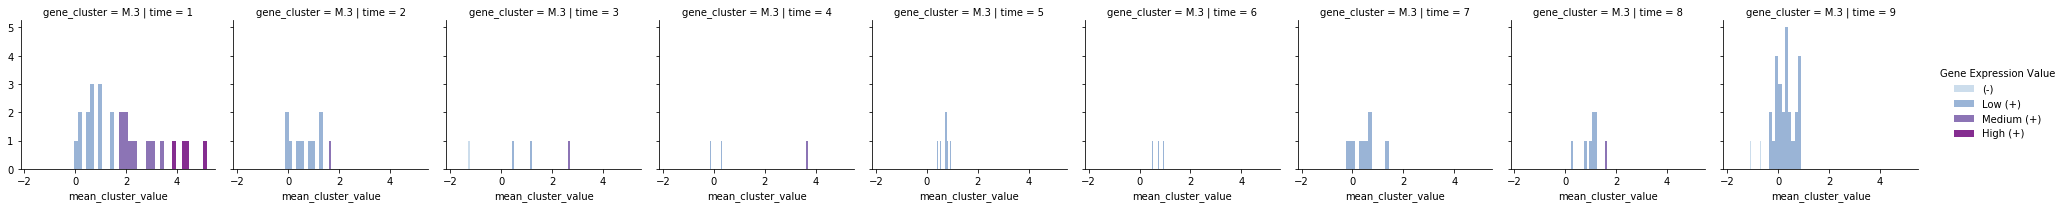

In [108]:
plot_expression_over_time('M.3')

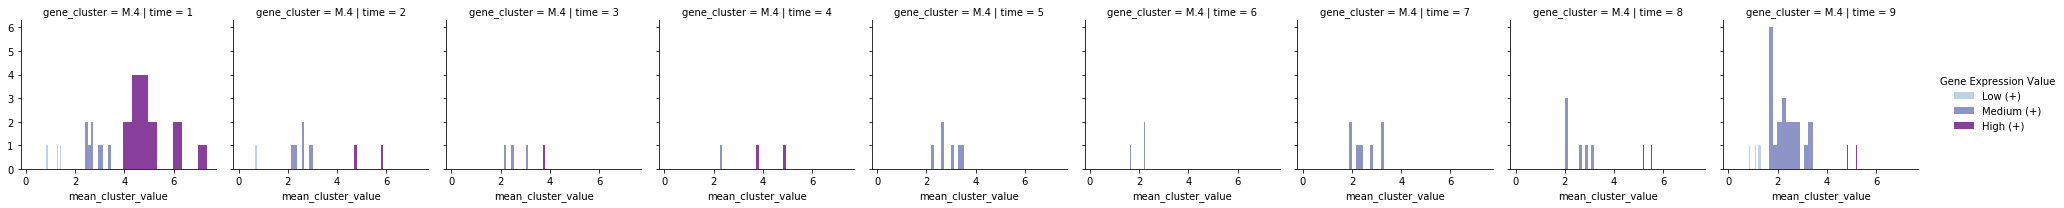

In [109]:
plot_expression_over_time('M.4')

In [53]:
# M.1
m1 = cluster_by_time_df.loc[cluster_by_time_df['gene_cluster'] == 'M.1']
m1 = m1[['time', 'mean_cluster_value']].groupby(by=['time'], as_index=False).mean()

# M.2
m2 = cluster_by_time_df.loc[cluster_by_time_df['gene_cluster'] == 'M.2']
m2 = m2[['time', 'mean_cluster_value']].groupby(by=['time'], as_index=False).mean()

# M.3
m3 = cluster_by_time_df.loc[cluster_by_time_df['gene_cluster'] == 'M.3']
m3 = m3[['time', 'mean_cluster_value']].groupby(by=['time'], as_index=False).mean()

#M.4
m4 = cluster_by_time_df.loc[cluster_by_time_df['gene_cluster'] == 'M.4']
m4 = m4[['time', 'mean_cluster_value']].groupby(by=['time'], as_index=False).mean()

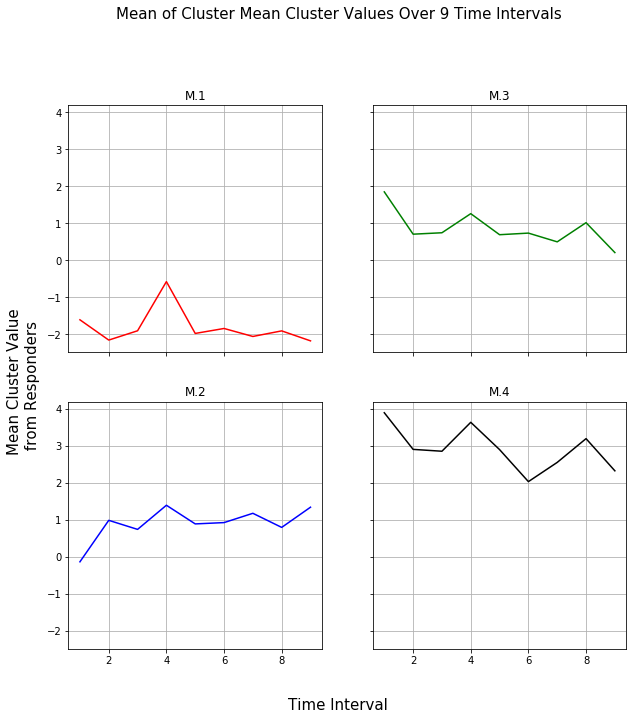

In [88]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,10))

# M.1
ax[0, 0].plot(m1['time'].values, m1['mean_cluster_value'].values, color='r')
ax[0, 0].set_title('M.1')
ax[0, 0].grid(True)

# M.2
ax[1, 0].plot(m2['time'].values, m2['mean_cluster_value'].values, color='b')
ax[1, 0].set_title('M.2')
ax[1, 0].grid(True)

# M.3
ax[0, 1].plot(m3['time'].values, m3['mean_cluster_value'].values, color='g')
ax[0, 1].set_title('M.3')
ax[0, 1].grid(True)

# M.4
ax[1, 1].plot(m4['time'].values, m4['mean_cluster_value'].values, color='k')
ax[1, 1].set_title('M.4')
ax[1, 1].grid(True)

# Label plots
fig.text(0.5, 1, 'Mean of Cluster Mean Cluster Values Over 9 Time Intervals', ha='center', fontsize=15) # x-axis
fig.text(0.5, 0.04, 'Time Interval', ha='center', fontsize=15) # x-axis
fig.text(0.04, 0.5, 'Mean Cluster Value \n from Responders', va='center', rotation='vertical', fontsize=15) # y-axis

plt.show()